## Standard Imports

In [1]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as seaborn
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import SymLogNorm as symlog
import pandas as pd
import numpy as np
import matplotlib

#Set this lower if the plots are offensively large to you
matplotlib.rcParams['savefig.dpi'] = 100 

# Load the data and do some cursory checks

In [3]:
!ls

Exploratory.ipynb  sample_submission.csv  test.csv  train.csv


In [4]:
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')
sample_submission_set = pd.read_csv('sample_submission.csv')

In [5]:
train_set.head()

row_id       x       y  accuracy    time    place_id
0       0  0.7941  9.0809        54  470702  8523065625
1       1  5.9567  4.7968        13  186555  1757726713
2       2  8.3078  7.0407        74  322648  1137537235
3       3  7.3665  2.5165        65  704587  6567393236
4       4  4.0961  1.1307        31  472130  7440663949

In [6]:
print(train_set.shape)
N_TRAIN_ROWS = float(train_set.shape[0])

(29118021, 6)


In [7]:
print(test_set.shape)
N_TEST_ROWS = float(test_set.shape[0])

(8607230, 5)


# Exploratory Data Analysis

(-2, 102)

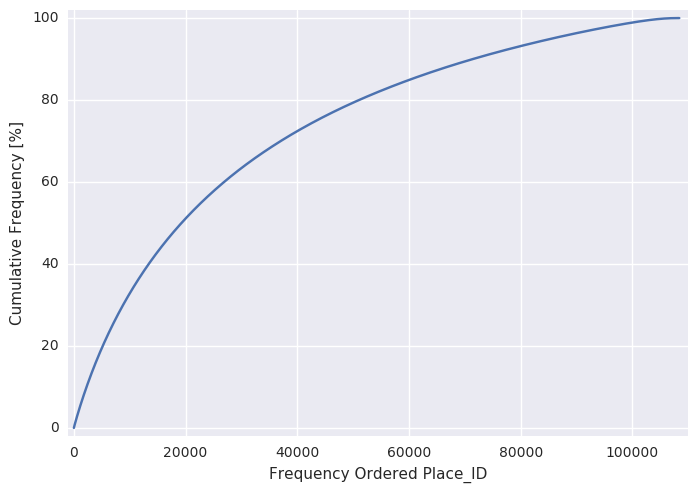

In [8]:
cumul_freq_id_per_place_id = np.cumsum(np.array(train_set.place_id.value_counts()))/(N_TRAIN_ROWS)*100.

plt.plot(cumul_freq_id_per_place_id)
plt.xlabel("Frequency Ordered Place_ID")
plt.ylabel("Cumulative Frequency [%]")
plt.xlim(-1000, 110000)
plt.ylim(-2, 102)

A cumulative frequency plot shows that to capture 80% of the data we need about 50K Place_ids. It also makes one hot encoding nearly impossible on a reasonable machine.

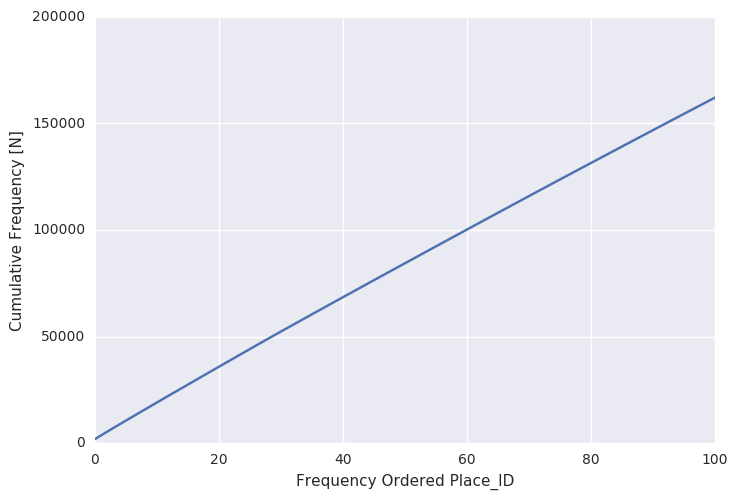

In [9]:
cumul_freq_id_per_place_id = np.cumsum(np.array(train_set.place_id.value_counts()))
plt.plot(cumul_freq_id_per_place_id)
plt.xlabel("Frequency Ordered Place_ID")
plt.ylabel("Cumulative Frequency [N]")
plt.xlim(0, 100)
plt.ylim(0, 200000);

Unsurprisingly with the above distribution, the first 100 most frequent place_ids represent 160K, or just over half a percent of the total checkins. Also note that it's linear over small spans in sorted place_id.

In [10]:
# This block builds a new dataframe with frequencies for place_id
k = train_set.place_id.value_counts()
train_freq = pd.DataFrame(data={'place_id': k.index, 'place_freq': k.values})
del k
train_freq.head()

place_freq    place_id
0        1849  8772469670
1        1802  1623394281
2        1757  1308450003
3        1738  4823777529
4        1718  9586338177

In [11]:
# Make a second training set that has a frequency column
train_set_2 = pd.merge(train_set, train_freq, how='left', on='place_id').sort_values('place_freq', ascending=False)

## Exploratory -- Visualize the first 100 components Spatially

In [12]:
# Visualize the first 100 components
train_set_100_components = train_set_2[:cumul_freq_id_per_place_id[100]].copy()

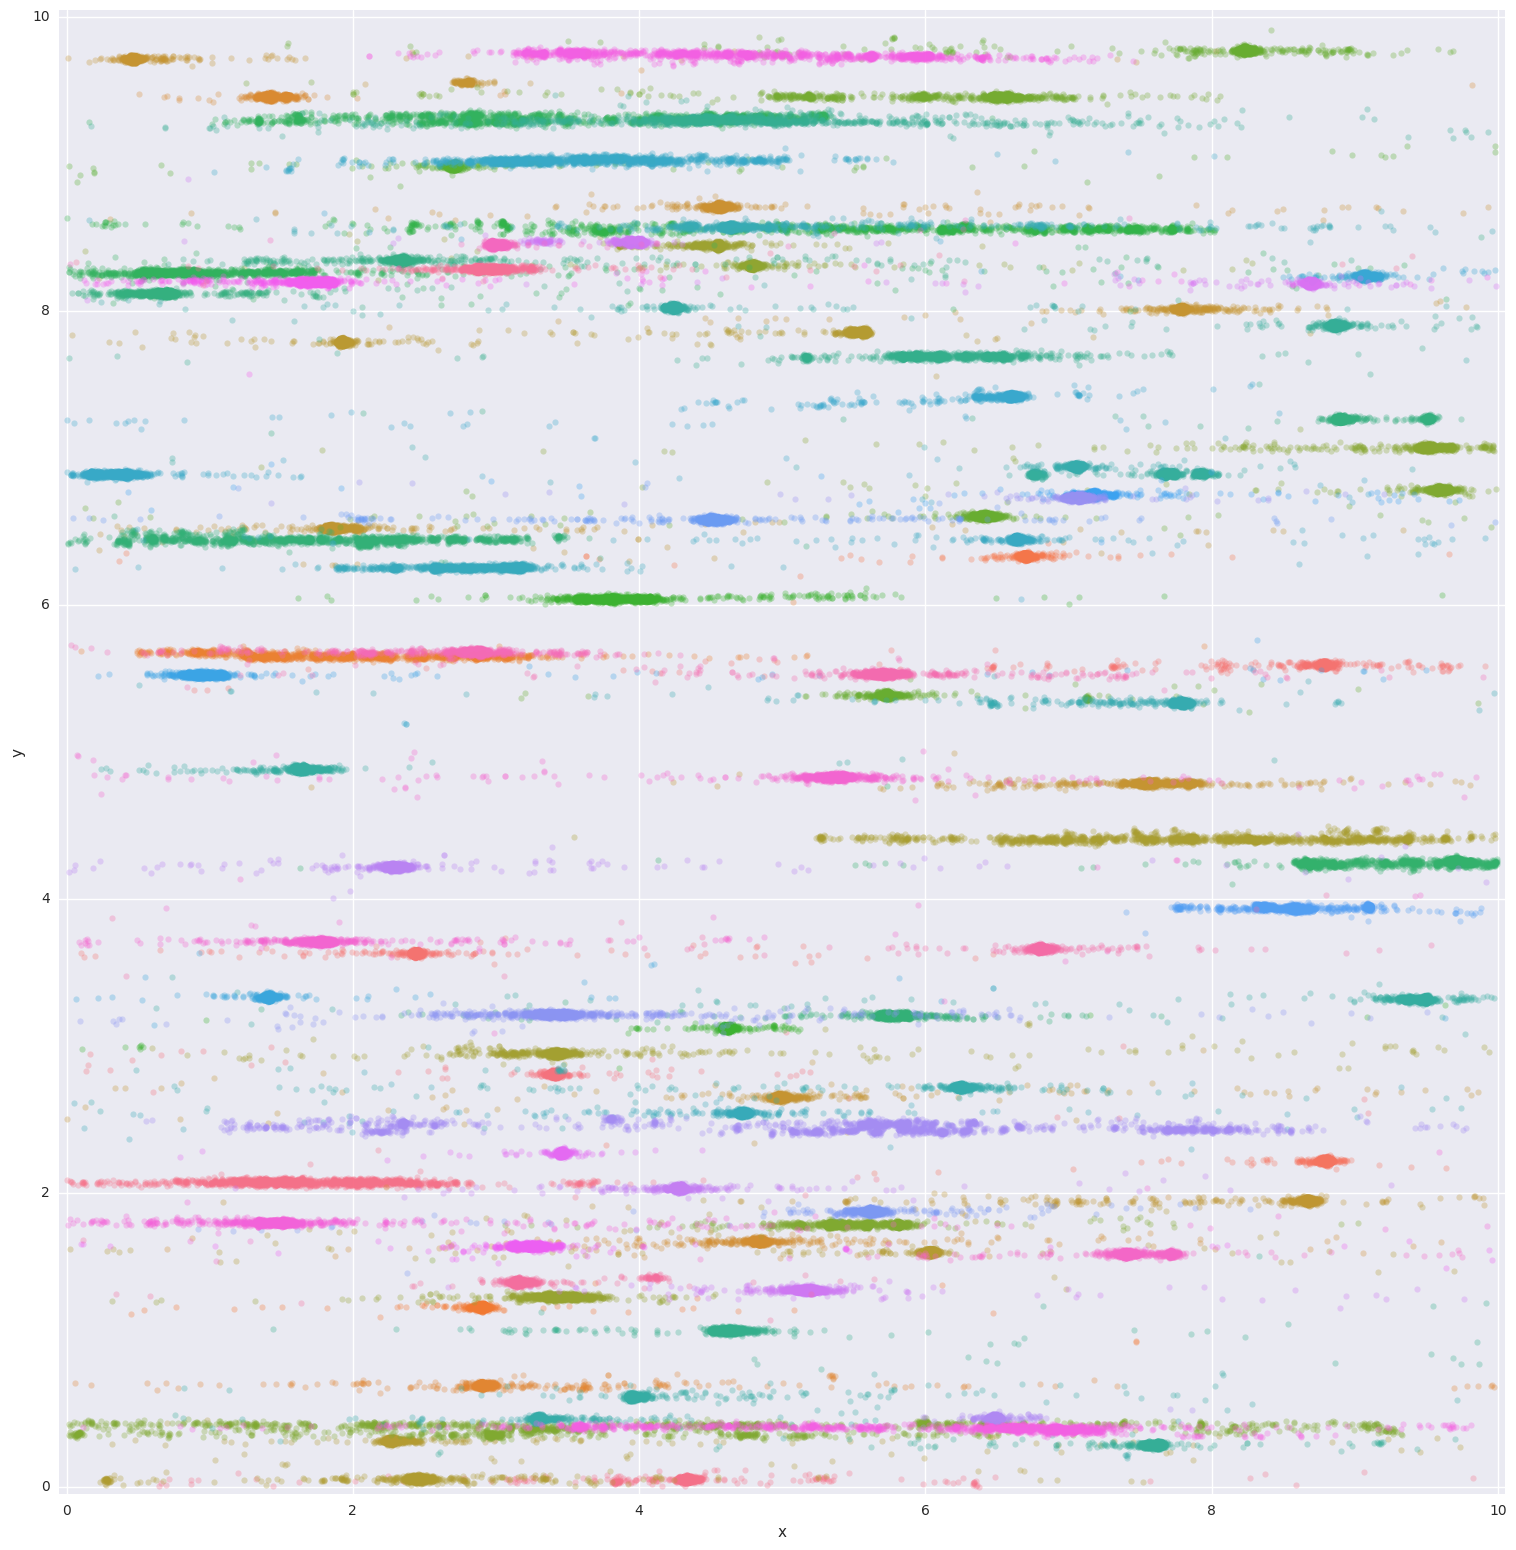

In [13]:
seaborn.lmplot(data=train_set_100_components, x='x', y='y', hue='place_freq', palette='husl',
           legend=False, fit_reg=False, scatter_kws={'alpha':0.3})
plt.xlim(-0.05, 10.05)
plt.ylim(-0.05, 10.05)
plt.gcf().set_size_inches(18, 18)

As others have shown, there is much more variability in x than in y. It's pretty weird, but maybe the buildings are horizontal? 

In [14]:
k = train_set_2[cumul_freq_id_per_place_id[40000]:cumul_freq_id_per_place_id[40100]]
seaborn.lmplot(data=k, x='x', y='y', hue='place_id', palette='husl',
           legend=False, fit_reg=False, scatter_kws={'alpha':0.3})

plt.gcf().set_size_inches(18, 18)
plt.xlim(-0.05, 10.05)
plt.ylim(-0.05, 10.05)
del k

The patterns in the first 100 place_ids seem to hold up for a few place ids in the middle of the pack, but as expected, there are substantially less counts.

## Exploratory -- Spatiotemporal

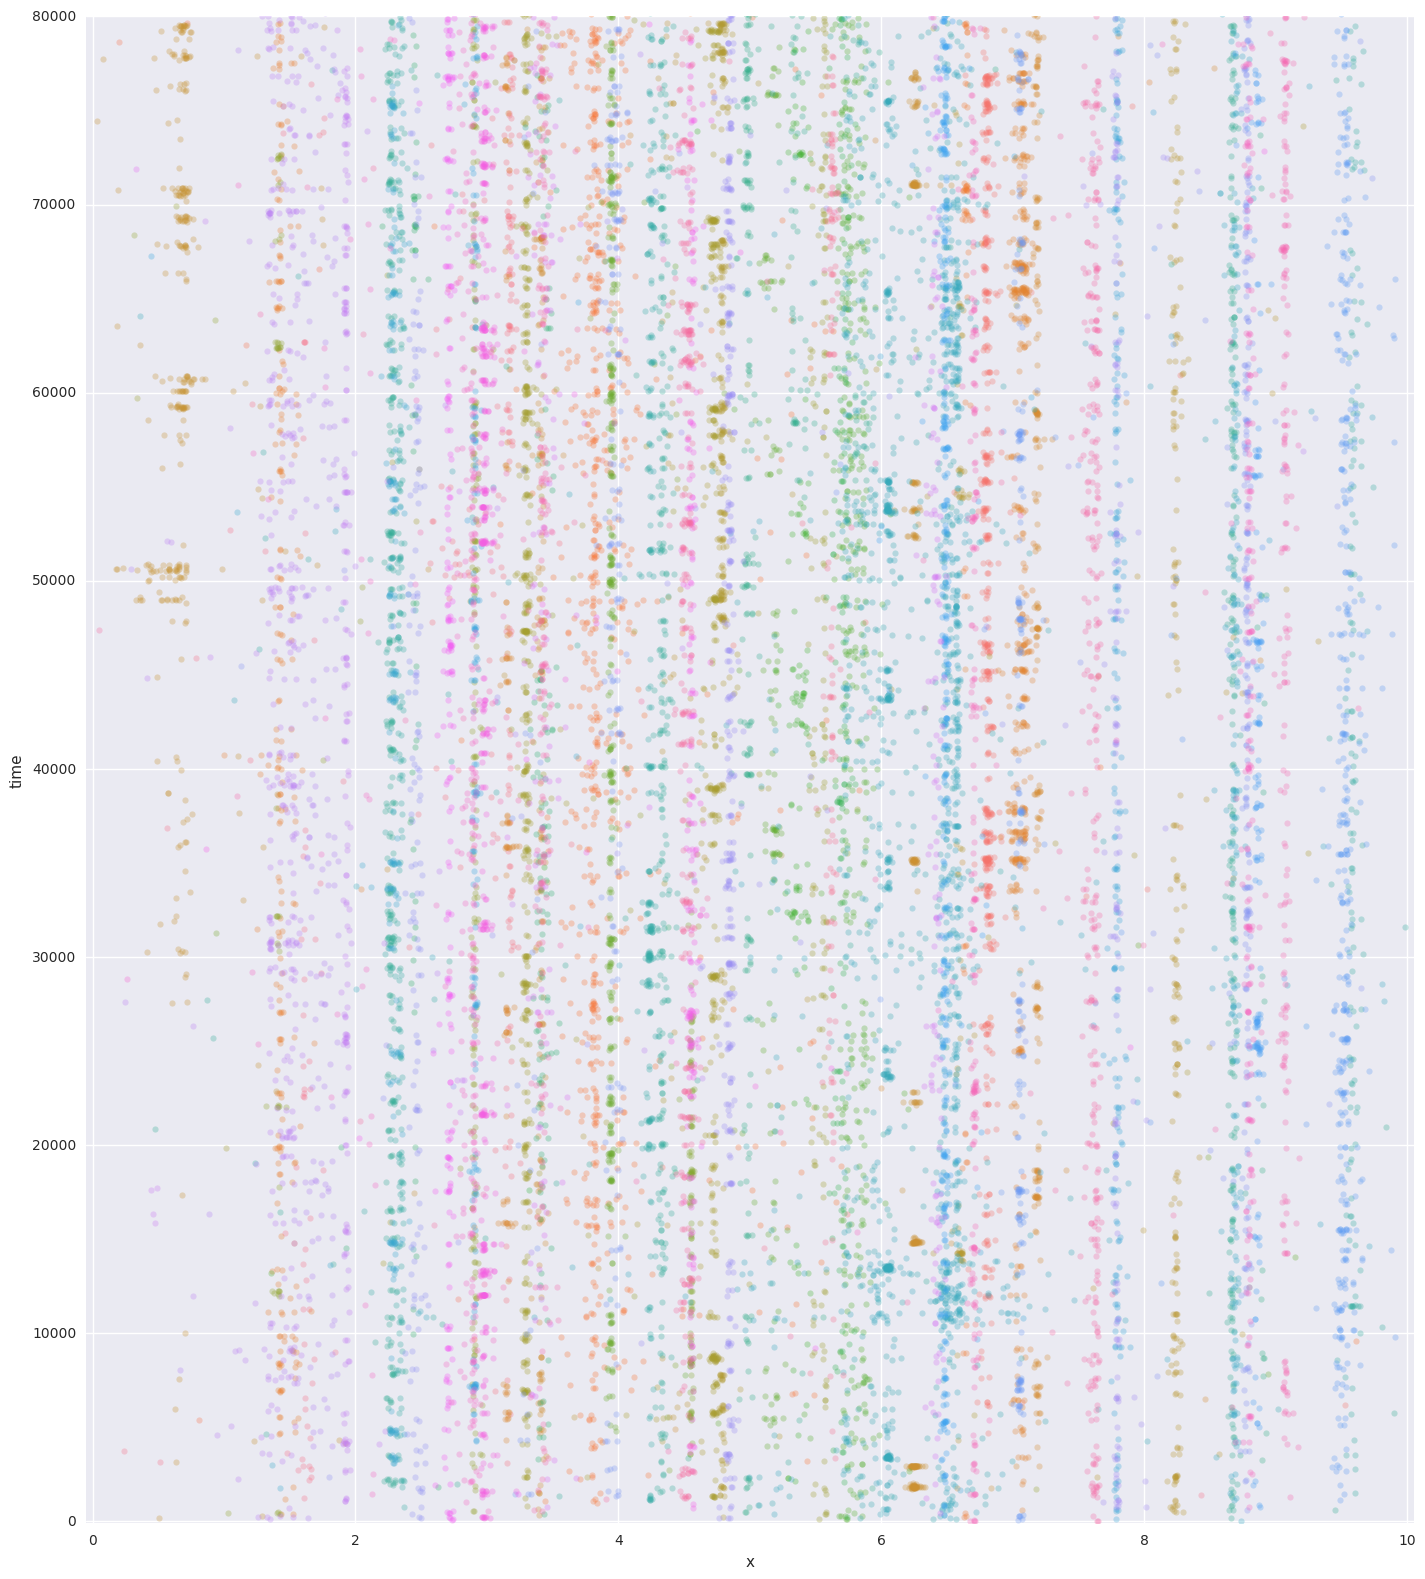

In [15]:
k = train_set_2[cumul_freq_id_per_place_id[0]:cumul_freq_id_per_place_id[100]]
seaborn.lmplot(data=k, x='x', y='time', hue='place_id', palette='husl',
           legend=False, fit_reg=False, scatter_kws={'alpha':0.3})

plt.gcf().set_size_inches(18, 18)
plt.xlim(-0.05, 10.05)
plt.ylim(-100, 80000)
del k

A few observations. 

1. There are two marked bands around 250K and 450K where the density is lower. A possible third marked band at 550K as well. These probably correspond to seasonal dips in checkins, probably for holidays.
2. It's not uncommon for a certain place_id to only be active for a limited portion of the time window. A lot of places start and stop. Given that the test set is in the future, perhaps place_ids that are stopped should be deweighted for classification.


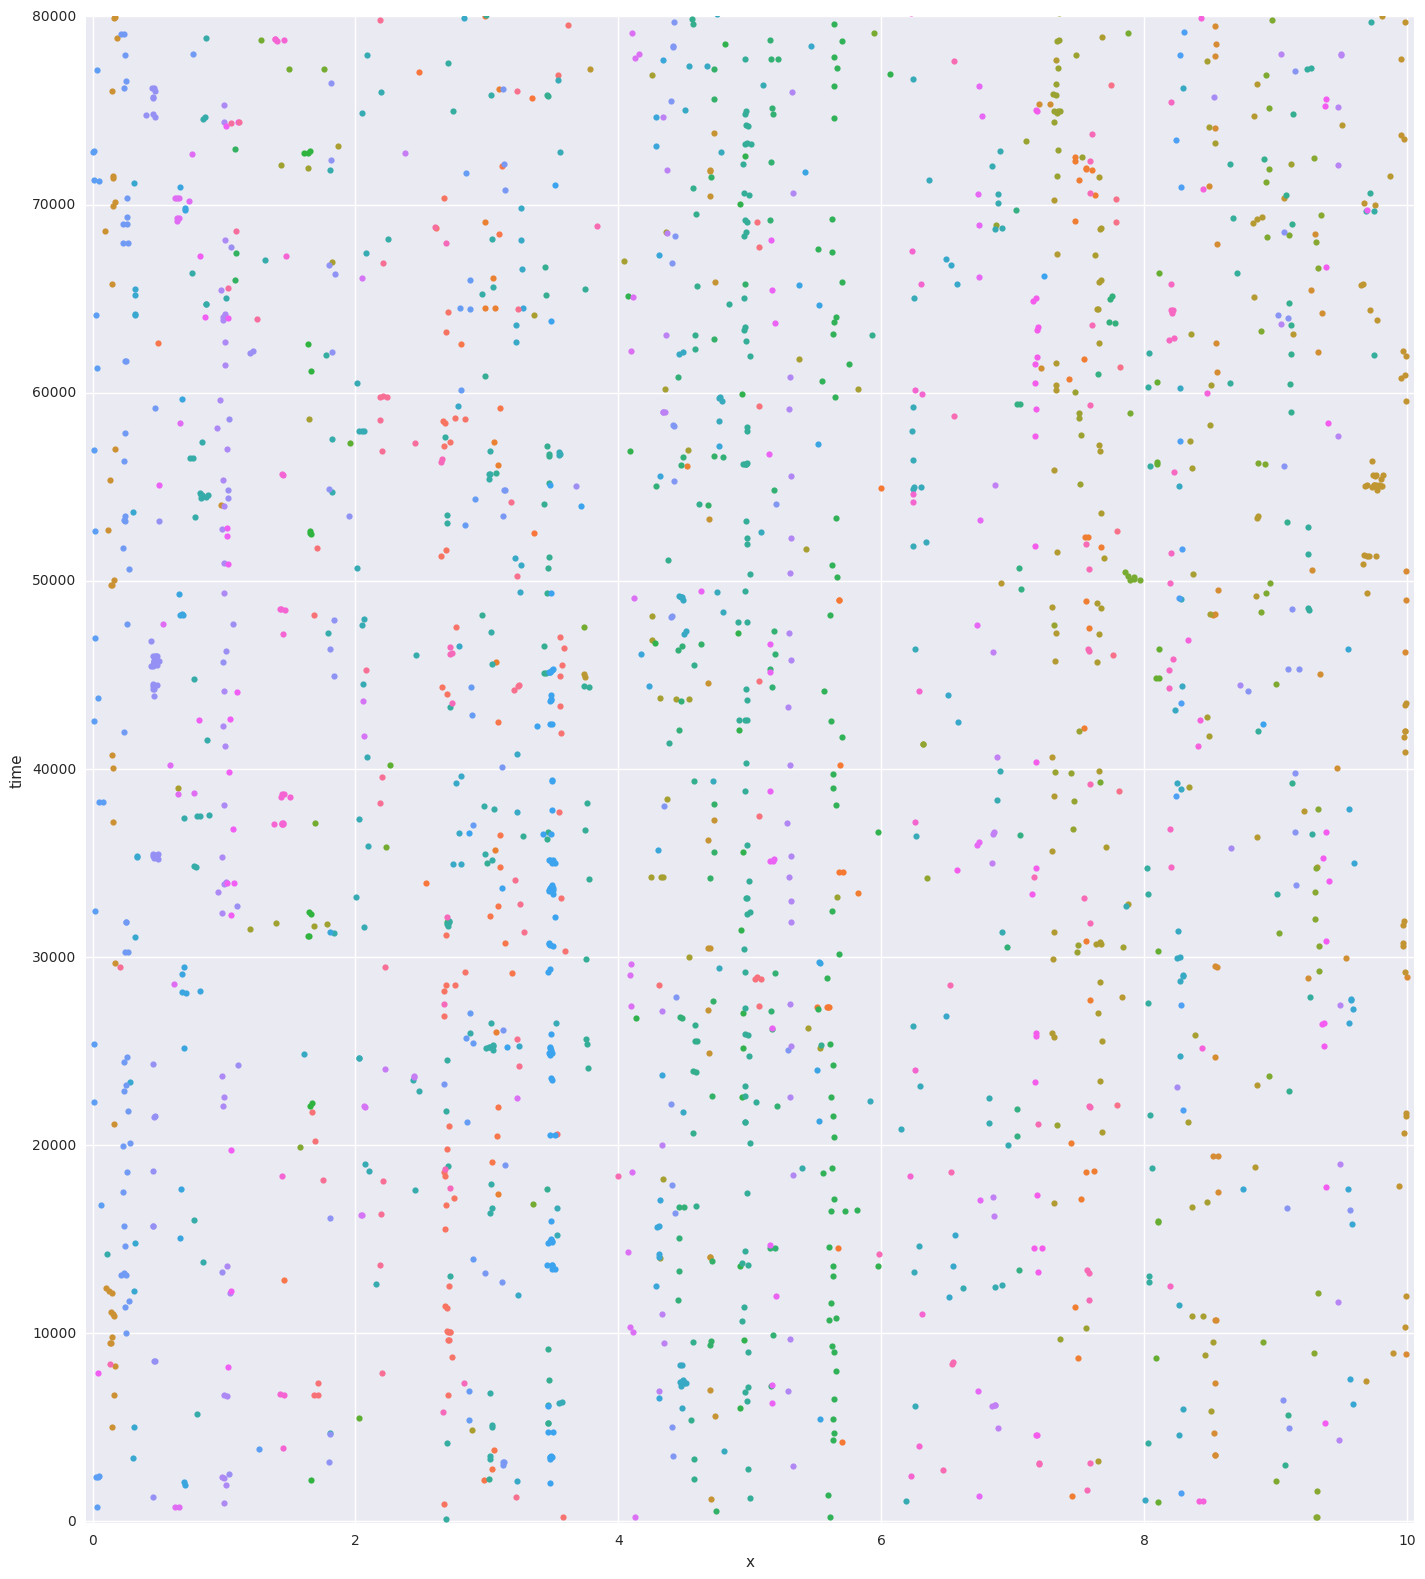

In [16]:
k = train_set_2[cumul_freq_id_per_place_id[40000]:cumul_freq_id_per_place_id[40100]]
seaborn.lmplot(data=k, x='x', y='time', hue='place_id', palette='husl',
           legend=False, fit_reg=False, scatter_kws={'alpha':1})

plt.gcf().set_size_inches(18, 18)
plt.xlim(-0.05, 10.05)
plt.ylim(-100, 80000)
del k

In [17]:
k = train_set_2[cumul_freq_id_per_place_id[0]:cumul_freq_id_per_place_id[100]]
seaborn.lmplot(data=k, x='y', y='time', hue='place_id', palette='husl',
           legend=False, fit_reg=False, scatter_kws={'alpha':1})

plt.gcf().set_size_inches(18, 18)
plt.xlim(-0.05, 10.05)
plt.ylim(-100, 80000)
del k

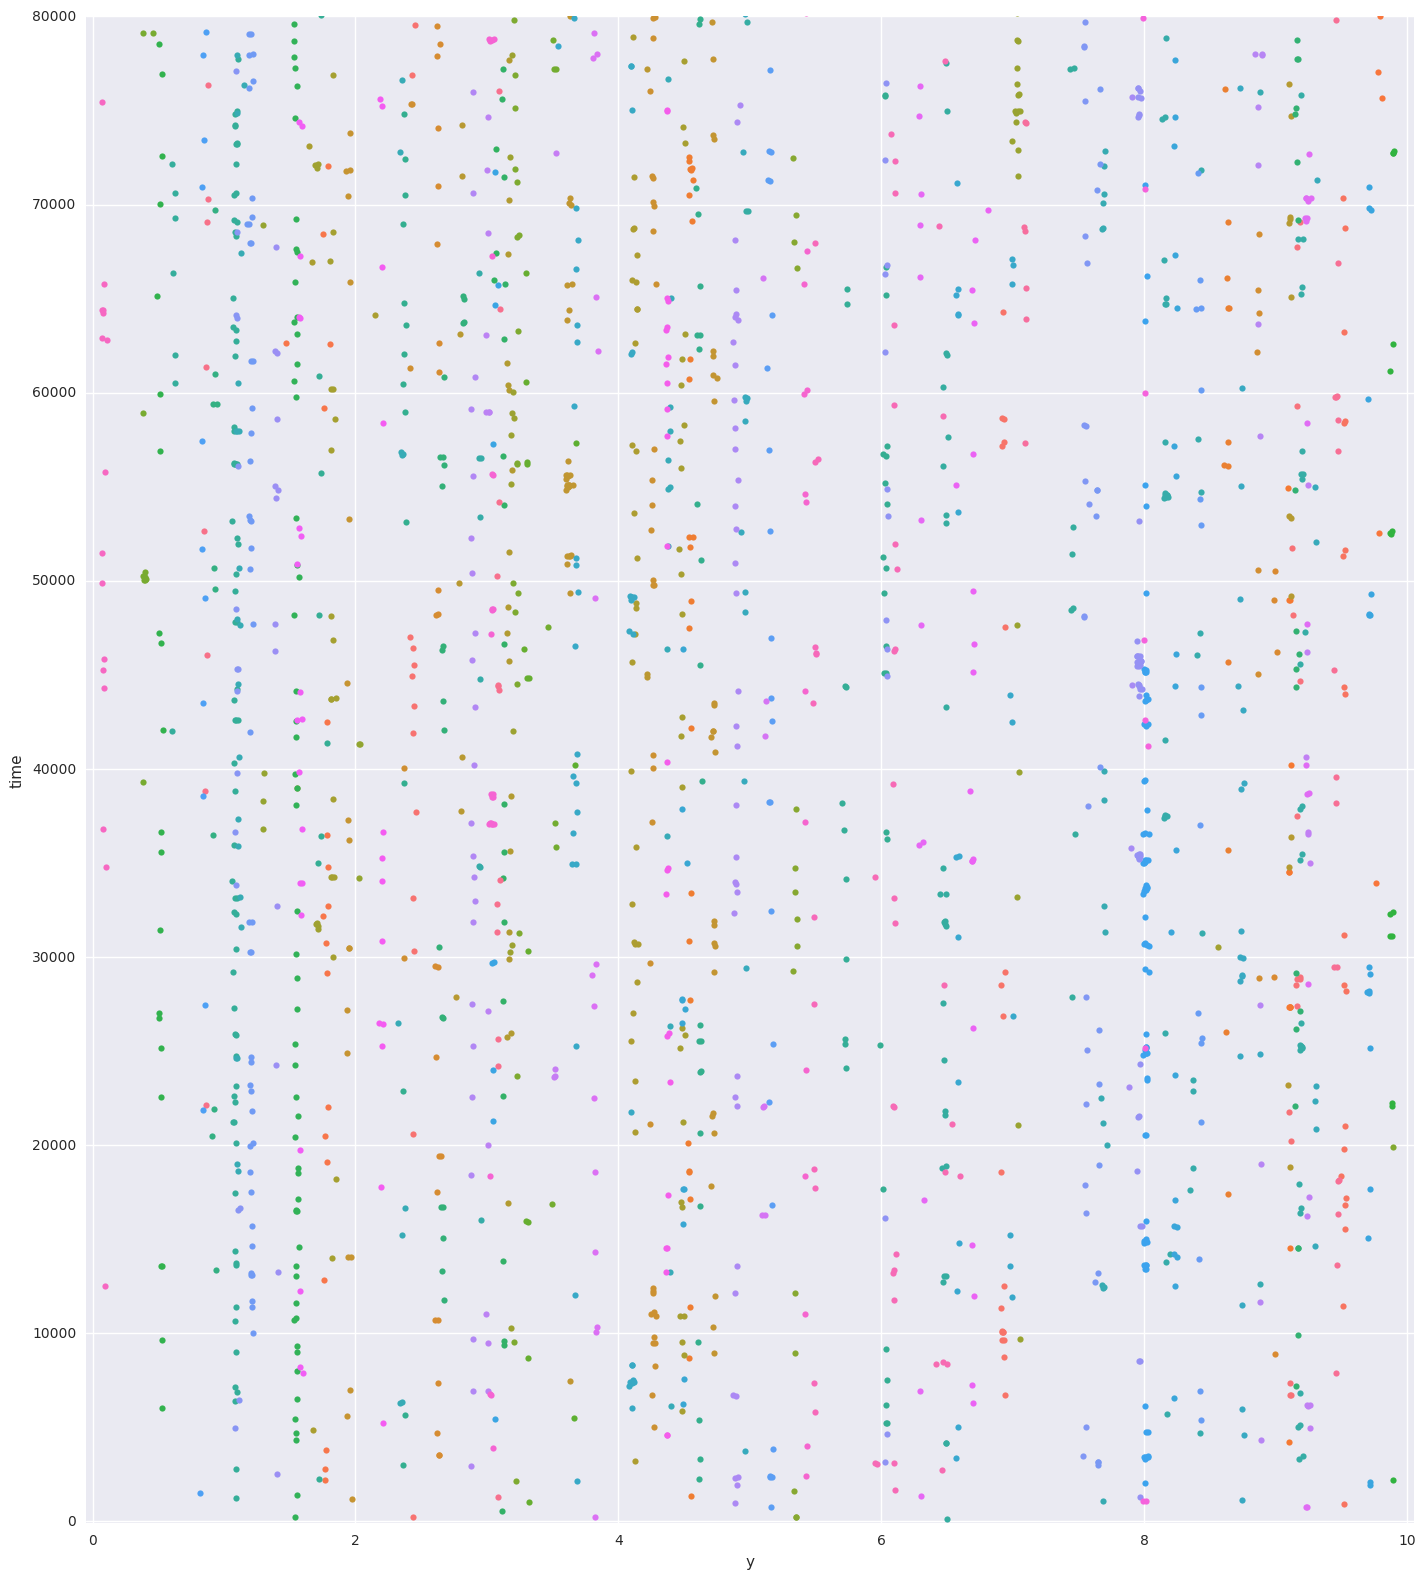

In [18]:
k = train_set_2[cumul_freq_id_per_place_id[40000]:cumul_freq_id_per_place_id[40100]]
seaborn.lmplot(data=k, x='y', y='time', hue='place_id', palette='husl',
           legend=False, fit_reg=False, scatter_kws={'alpha':1})

plt.gcf().set_size_inches(18, 18)
plt.xlim(-0.05, 10.05)
plt.ylim(-100, 80000)
del k

Same sort of patterns in x and y. There is marked heterogeneity in time, but the place_ids with less check-ins do not seem to be markedly different from the most frequent check-ins.

### Spatial patterns for the 100 most common places

In [19]:
seaborn.jointplot(data=train_set_2[:cumul_freq_id_per_place_id[100]], x='x', y='y', kind='hex')

These seem nicely localized. 

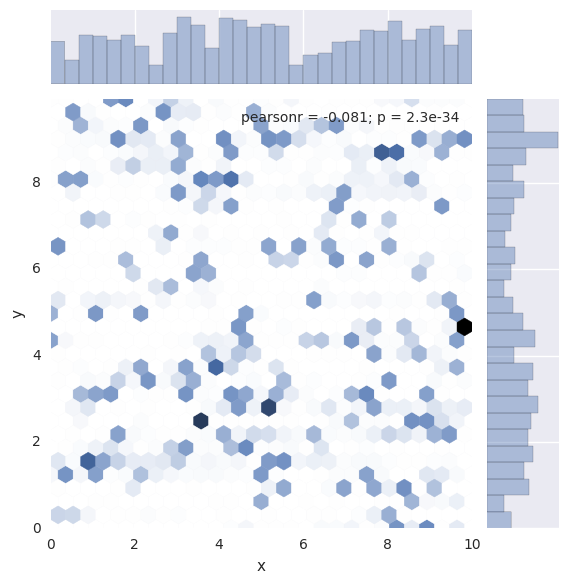

In [20]:
seaborn.jointplot(data=train_set_2[cumul_freq_id_per_place_id[40000]:cumul_freq_id_per_place_id[40100]], x='x', y='y', kind='hex')

The less common place_ids are substantially less well localized in space, but essentially the same characteristics as the more frequent place_ids.

### Spatiotemporal patterns for the 100 most common places

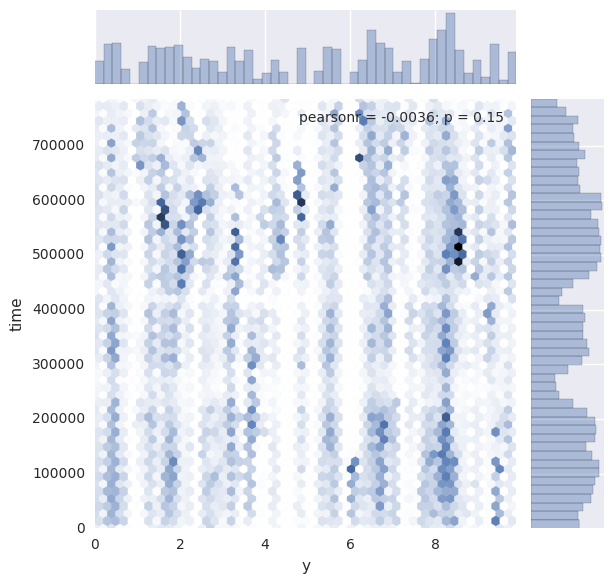

In [21]:
seaborn.jointplot(data=train_set_2[:cumul_freq_id_per_place_id[100]], x='y', y='time', kind='hex')

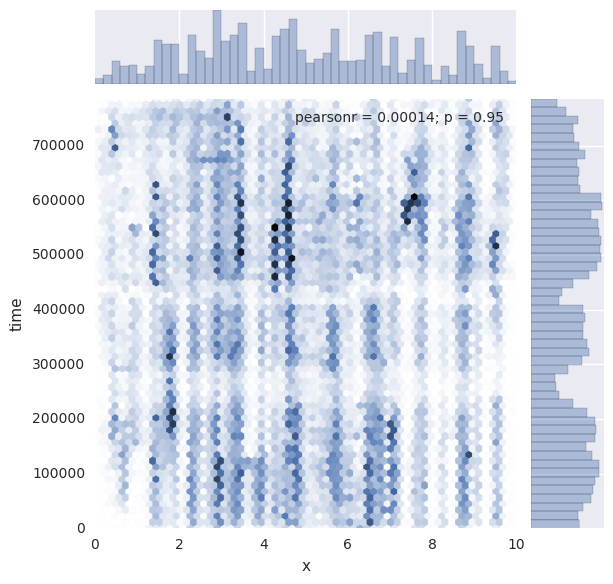

In [22]:
seaborn.jointplot(data=train_set_2[:cumul_freq_id_per_place_id[100]], x='x', y='time', kind='hex')

## Spatial patterns for all rows

In [23]:
seaborn.jointplot(data=train_set_2, x='x', y='y', kind='hex')

## Spatiotemporal patterns for all rows

In [24]:
seaborn.jointplot(data=train_set_2, x='x', y='time', kind='hex')

In [25]:
seaborn.jointplot(data=train_set_2, x='y', y='time', kind='hex')

We clearly see the two bands of decreased checkins, with a statistically robust third band likely as well (around time=550K)

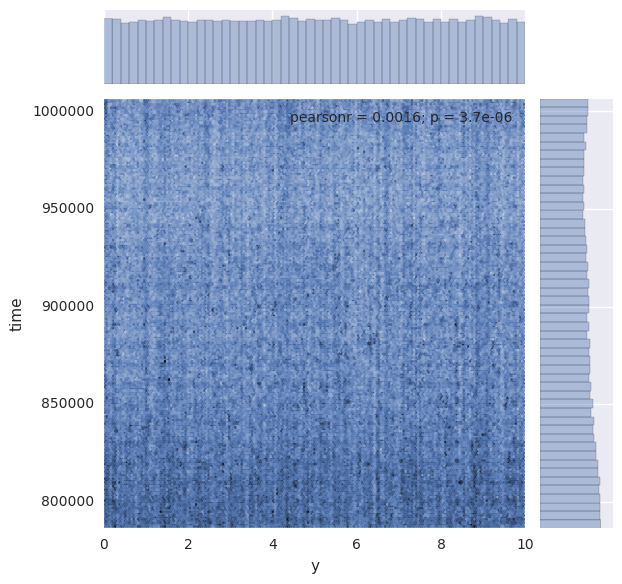

In [26]:
seaborn.jointplot(data=test_set, x='y', y='time', kind='hex')

A cursory examination of the test dataset (Shouldn't bias us too much) shows we don't have any such long timescale banding, and we see that time is (almost?) always larger than time in the training set. A slight horizontal banding is visible on a fairly regular pattern, which is probably the weekly (see below), but I don't want to "fit" the test dataset too much so I won't look at it further just yet.

## The Time Coordinate

There's good evidence that the time coordinate is in minutes, which would give us about a year and a half of data.

In [27]:
train_set_2['time_julian_day'] = (train_set_2.time.values /60. /24.)
train_set_2['time_month_of_year'] = np.round(train_set_2.time_julian_day.values / 30.5 ) 
train_set_2['time_day_of_month'] = np.floor(train_set_2.time_julian_day.values % 30.5)
train_set_2['time_day_of_week'] = np.floor(train_set_2.time_julian_day.values % 7)
train_set_2['time_of_day'] = (train_set_2.time_julian_day.values % 1.0)*24.

In [28]:
train_set_2.head()

row_id       x       y  accuracy    time    place_id  place_freq  \
12198378  12198378  2.8900  8.2893        65  523333  8772469670        1849   
9672133    9672133  2.8676  8.2966        61   53899  8772469670        1849   
3281879    3281879  2.8757  8.2641        70   50943  8772469670        1849   
9452582    9452582  2.8589  8.2940        55   43631  8772469670        1849   
22150520  22150520  2.8914  8.2867       916  491627  8772469670        1849   

          time_julian_day  time_month_of_year  time_day_of_month  \
12198378       363.425694                12.0               27.0   
9672133         37.429861                 1.0                6.0   
3281879         35.377083                 1.0                4.0   
9452582         30.299306                 1.0               30.0   
22150520       341.407639                11.0                5.0   

          time_day_of_week  time_of_day  
12198378               6.0    10.216667  
9672133                2.0    10.316667  
3281879                0.0     9.050000  
9452582                2.0     7.183333  
22150520               5.0     9.783333

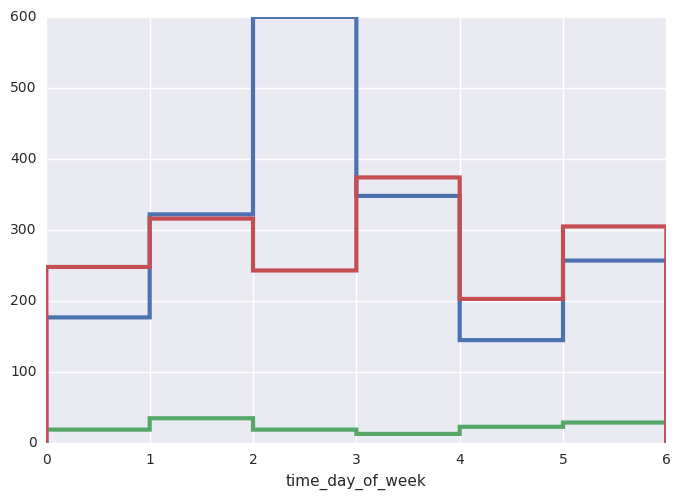

In [29]:
plt.xlim(0, 6)
seaborn.distplot(train_set_2[:cumul_freq_id_per_place_id[0]].time_day_of_week, 
                 kde=False, hist_kws={"histtype": "step", "linewidth": 3, 'alpha': 1.},
                bins=np.arange(7))
zz = 62283
seaborn.distplot(train_set_2[cumul_freq_id_per_place_id[zz-1]:cumul_freq_id_per_place_id[zz]].time_day_of_week,
                 kde=False, hist_kws={"histtype": "step", "linewidth": 3, 'alpha': 1.},
                bins=np.arange(7),)
zz = 11
seaborn.distplot(train_set_2[cumul_freq_id_per_place_id[zz-1]:cumul_freq_id_per_place_id[zz]].time_day_of_week,
                 kde=False, hist_kws={"histtype": "step", "linewidth": 3, 'alpha': 1.},
                bins=np.arange(7),)

Certain place_ids at least, exhibited very substantial day of the week variability.

In [30]:
plt.xlim(0, 600)
seaborn.distplot(train_set_2[:cumul_freq_id_per_place_id[0]].time_julian_day, 
                 kde=False, hist_kws={"histtype": "step", "linewidth": 3, 'alpha': 1.})
zz = 62283
seaborn.distplot(train_set_2[cumul_freq_id_per_place_id[zz-1]:cumul_freq_id_per_place_id[zz]].time_julian_day,
                 kde=False, hist_kws={"histtype": "step", "linewidth": 3, 'alpha': 1.})
zz = 11
seaborn.distplot(train_set_2[cumul_freq_id_per_place_id[zz-1]:cumul_freq_id_per_place_id[zz]].time_julian_day,
                 kde=False, hist_kws={"histtype": "step", "linewidth": 3, 'alpha': 1.})

Certain place_ids had clearly nonrandom variations over the time period involved, however, we cannot really use this to predict accurately into the future, as time is larger than this in our test dataset. There might be an exception possible for the day of the week or day of the month, as well as if a place_id stopped having checkins before the end of the training set, implying the place_id is no longer accepting customers.

## The Accuracy Coordinate

In [31]:
train_freq.sort_values('place_id', inplace=True)

In [32]:
train_freq['x_std'] = train_set_2.groupby('place_id').x.std().values
train_freq['y_std'] = train_set_2.groupby('place_id').y.std().values
train_freq['x_median'] = train_set_2.groupby('place_id').x.median().values
train_freq['y_median'] = train_set_2.groupby('place_id').y.median().values
train_freq['acc_mean'] = train_set_2.groupby('place_id').accuracy.mean().values

In [33]:
train_freq.head()

place_freq    place_id     x_std     y_std  x_median  y_median  \
93441           78  1000015801  0.208356  0.015983   2.69150   5.54925   
82954           95  1000017288  0.338709  0.010262   7.10790   4.34700   
13440          563  1000025138  0.076025  0.010221   0.98280   5.56990   
4251           961  1000052096  0.473961  0.011314   2.80640   5.83390   
101274          60  1000063498  1.523148  0.073799   4.02725   7.55045   

          acc_mean  
93441    80.307692  
82954    61.263158  
13440    73.147425  
4251     78.797086  
101274  149.966667

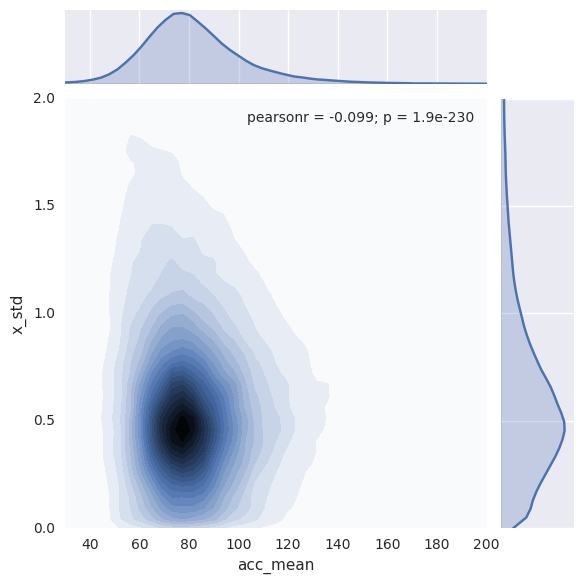

In [34]:
k = train_freq[train_freq.place_freq > 5]
seaborn.jointplot('acc_mean', 'x_std', data=k, kind='kde', xlim=(30, 200), ylim=(0,2), joint_kws={'n_levels':30})
seaborn.jointplot('acc_mean', 'y_std', data=k, kind='kde', xlim=(30, 200), ylim=(0,0.1), joint_kws={'n_levels':30})

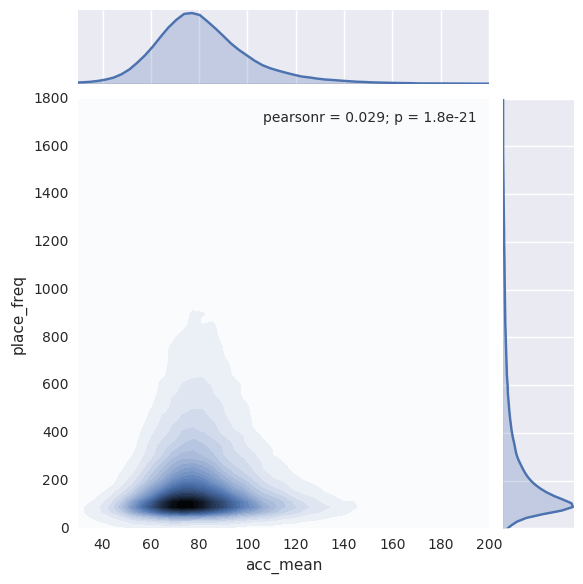

In [35]:
seaborn.jointplot('acc_mean', 'place_freq', data=k, kind='kde', xlim=(30, 200), ylim=(0, 1800),
                 joint_kws={'n_levels':30})

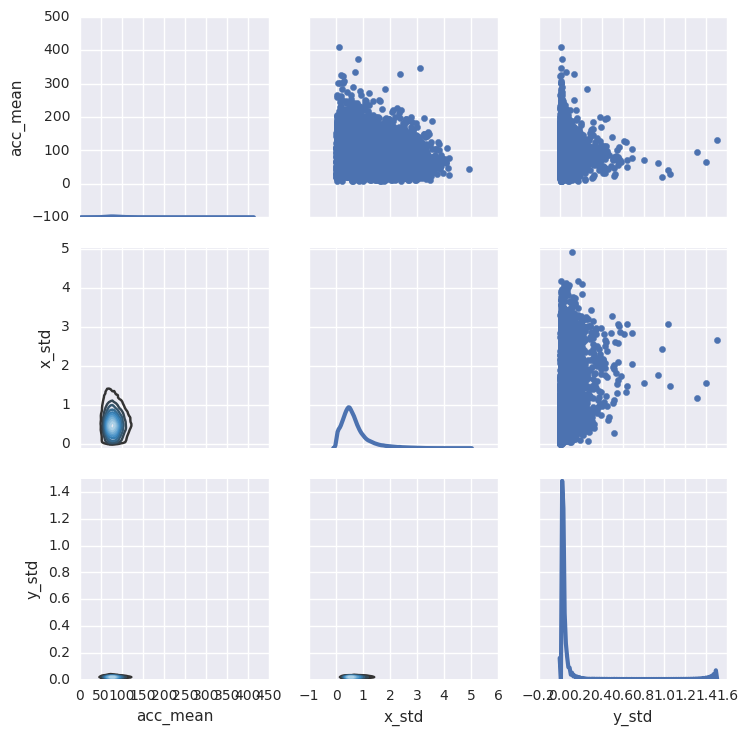

In [36]:
g = seaborn.PairGrid(train_freq[train_freq.place_freq > 5], vars=['acc_mean','x_std', 'y_std'])
g = g.map_upper(plt.scatter)
g = g.map_lower(seaborn.kdeplot, cmap="Blues_d")
g = g.map_diag(seaborn.kdeplot, lw=3, legend=False)

I don't know how useful the accuracy coordinate is ... it seems to only connect to the standard deviation of the x coordinate, and even then only slightly. Perhaps, I can do a cut of very innacurate points, and just visually inspect.

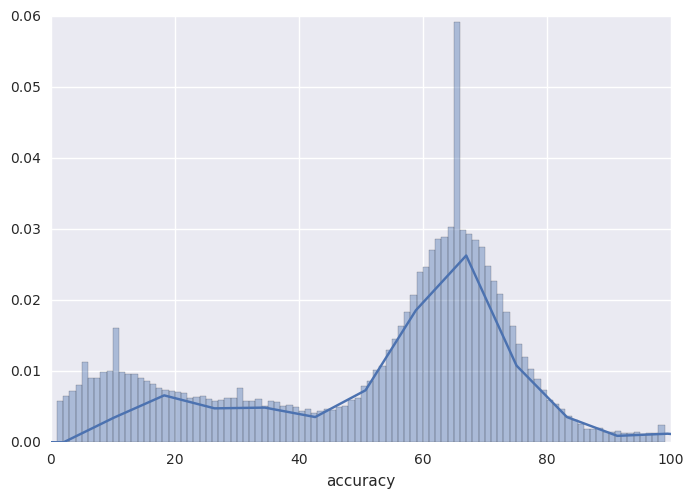

In [37]:
k = train_set_2[:cumul_freq_id_per_place_id[100]]
plt.xlim(0, 100)
seaborn.distplot(k.accuracy, bins=np.arange(100), kde=True)

### Before cuts

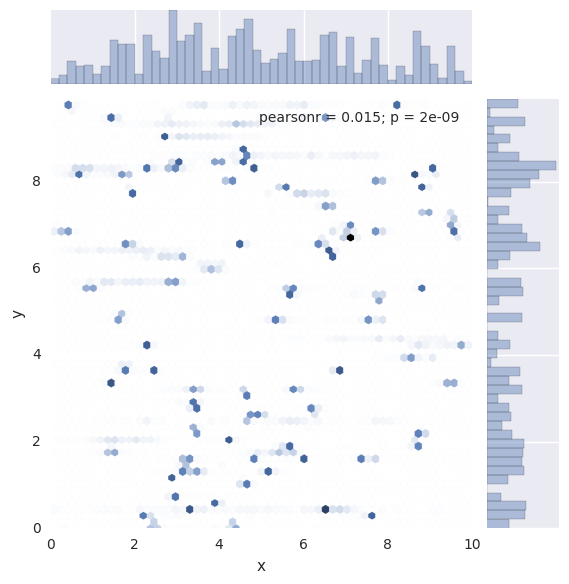

In [38]:
seaborn.jointplot(data=k, x='x', y='y', kind='hex')

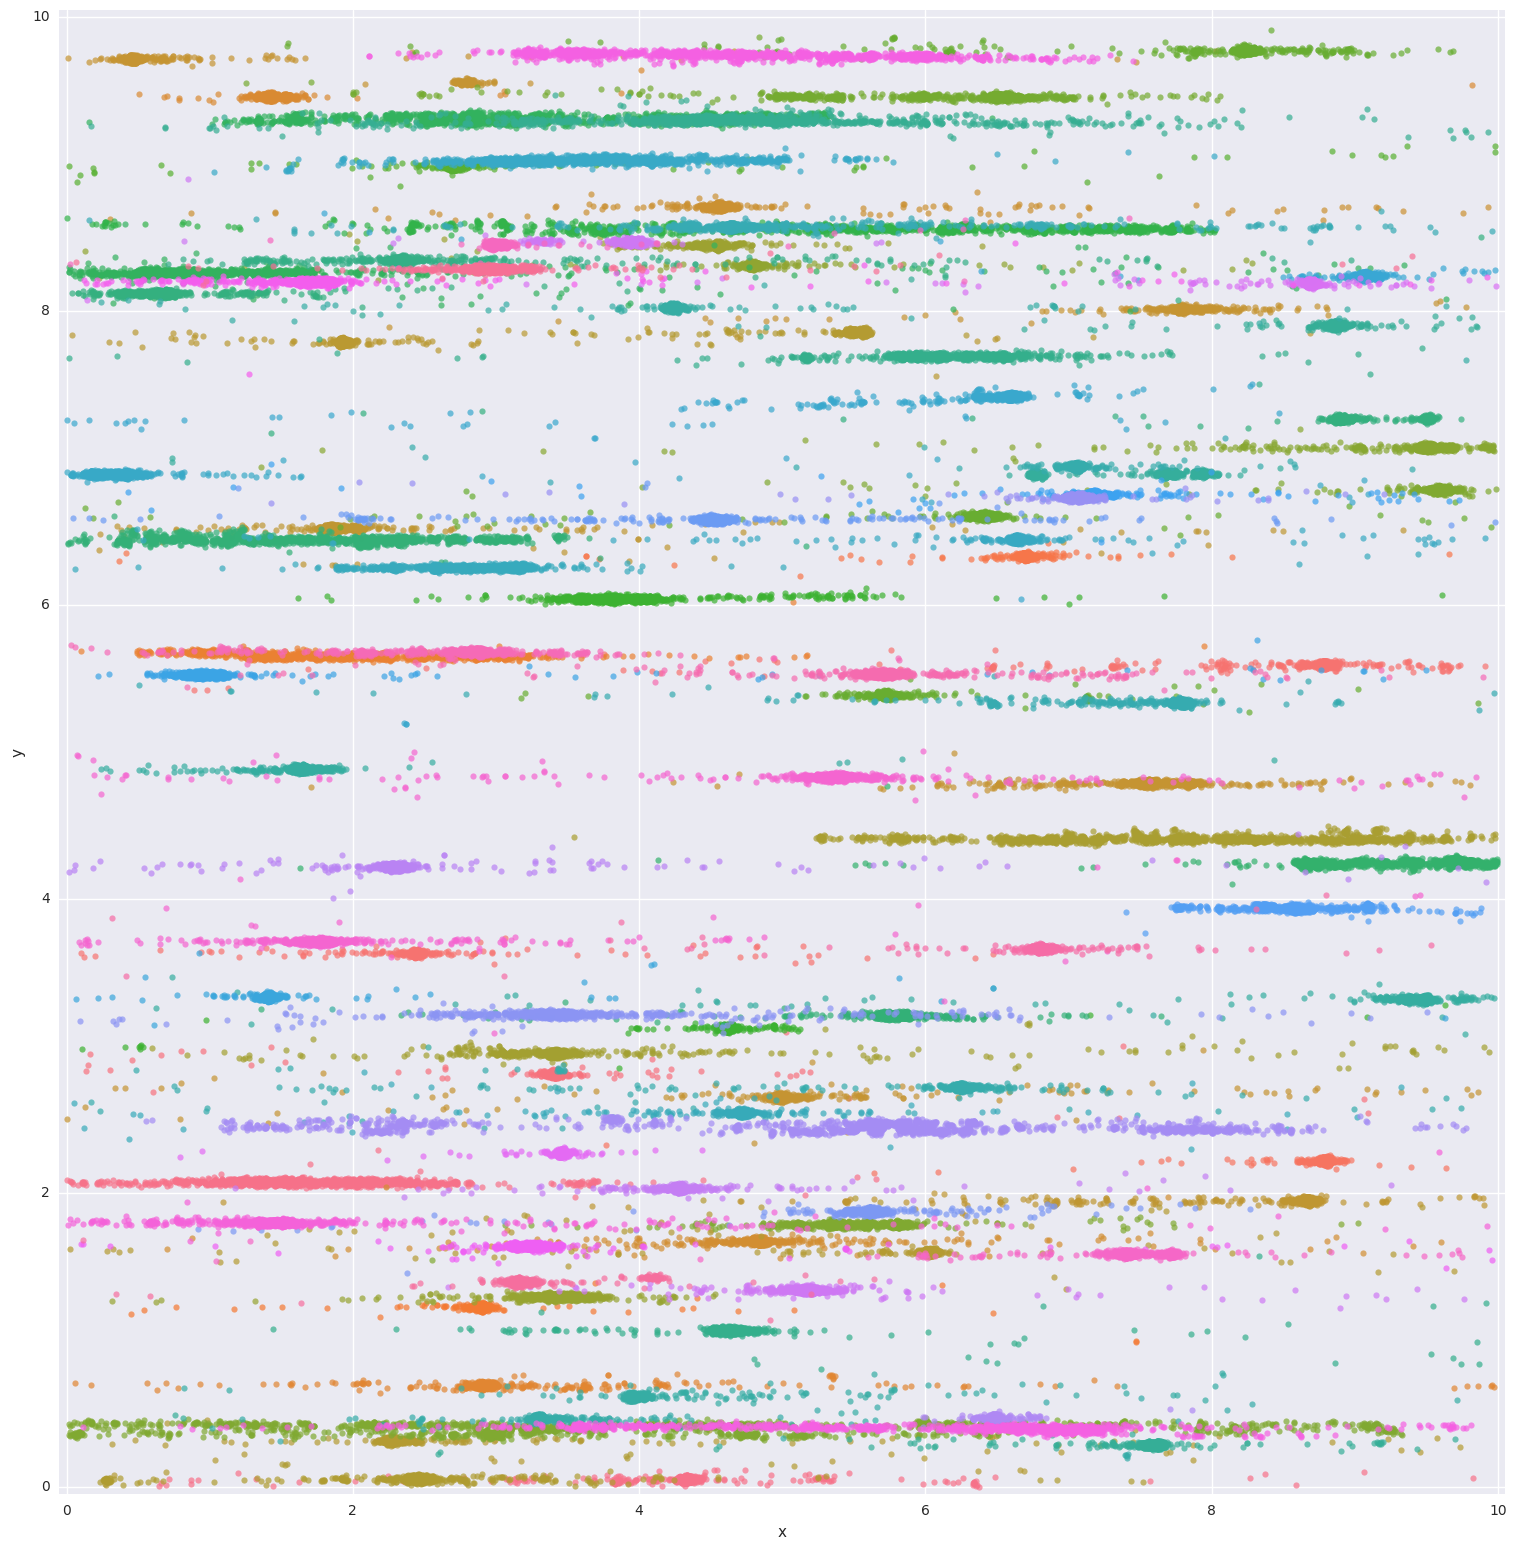

In [39]:
seaborn.lmplot(data=k, x='x', y='y', hue='place_freq', palette='husl',
           legend=False, fit_reg=False, scatter_kws={'alpha':0.7})
plt.xlim(-0.05, 10.05)
plt.ylim(-0.05, 10.05)
plt.gcf().set_size_inches(18, 18)

### After cuts

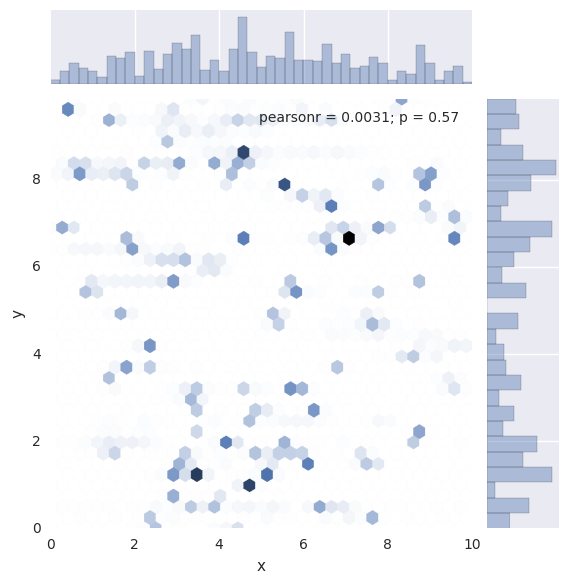

In [40]:
k = train_set_2[:cumul_freq_id_per_place_id[100]]
seaborn.jointplot(data=k[k.accuracy > 80.], x='x', y='y', kind='hex')

In [41]:
seaborn.lmplot(data=k[k.accuracy >= 80.], x='x', y='y', hue='place_freq', palette='husl',
           legend=False, fit_reg=False, scatter_kws={'alpha':0.7})
plt.xlim(-0.05, 10.05)
plt.ylim(-0.05, 10.05)
plt.gcf().set_size_inches(18, 18)

So this sets a relatively high accuracy cut ... and it looks a little different. But nothing to write home about. Other people's posts on the forums indicate the accuracy is strongly dependent on time, and by implementing an accuracy cut, effectively a time cut is being applied, which unevenly applies across place_ids.